Data Science Summer School - Split '16
======================================

Day 3 - part 1 - Feature selection
--------------------------

Matija Piškorec

v0.0.4

`kernel: Python 2.7`

Prerequisites
--------------

We will use [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) package for some of the plots and for visual style of Matplotlib's plots. If it is not already installed in your Anaconda distribution you can install it by `conda install seaborn` in Anaconda console. For more details see documentation for [`conda install`](http://conda.pydata.org/docs/commands/conda-install.html).

We will use the "Wisconsin Breast Cancer" dataset which contains 569 samples and 30 features, with target variable being either 0 (malign) or 1 (benign). It is available locally in this notebook's folder, but in general it is also available in scikit-learn through [`sklearn.datasets.load_breast_cancer`](http://scikit-learn.org/dev/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) (version 0.17.1), and you can load it with:

```python
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
```

And convert it to Pandas dataframe:

```Python
breast_cancer = pd.DataFrame(data=np.c_[breast_cancer['data'], breast_cancer['target']], 
                             columns=np.append(breast_cancer['feature_names'],'target'))
```

For other datasets available in scikit-learn see the documentation for [`sklearn.datasets`](http://scikit-learn.org/dev/modules/classes.html#module-sklearn.datasets).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

In [2]:
breast_cancer = pd.read_csv('breast_cancer.csv',index_col=0)
breast_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [3]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 568
Data columns (total 31 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

Although it is not strictly necessary in our case, we will follow a standard machine learning procedure and split our dataset into training and test set with [`sklearn.cross_validation.train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html), and perform all our analysis on the train set only.

In [4]:
from sklearn.cross_validation import train_test_split

In [5]:
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)
print 'Number of training examples: ' + str(len(breast_cancer_train))
print 'Number of test examples: ' + str(len(breast_cancer_test))

Number of training examples: 455
Number of test examples: 114


1. Feature selection
------------------

The main goal of feature selection is to select a subset of most "relevant" features in order to 1) improve the predictive performance, 2) lower computational costs of predictive modeling and 3) improve the interpretability of models.

Note the difference between the *feature selection*, where we select a subset of existing features, and *dimensionality reduction*, where we project our data onto a different feature space, usually because this different feature space has some beneficial mathematical properties. We will cover dimensionality reduction methods in the second part of these exercises.

Scikit-learn [user guide](http://scikit-learn.org/stable/user_guide.html) has a section on feature selection [[1]](#scikit-feature-selection). Some of the following examples are from Chapter 4 of the book "Python Machine Learning" [[2]](#pyml-ch4) and Chapter 5 of the book "Introduction to Machine Learning with Python" [[3]](#intro-ml-py-ch5). Also, a good overview of feature selection is series of blog posts "Selecting good features" from ["Diving into data"](http://blog.datadive.net/) blog [[4]](#diving-into-data).

1.1. Univariate feature selection
-----------------------------------

Univariate feature selection belongs to the *model-independent* method for feature selection, so called because they usually rely on statistical tests to evaluate feature relevance, instead of the predictive model. Out of these, *unsupervised* methods do not rely on the target variable, while *supervised* do. Probably the simplest unsupervised method is *variable variance* method, implemented in scikit-learn in [`sklearn.feature_selection.VarianceThreshold`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold), that excludes features which have variance below some threshold. Also, if we have two correlated features, we can remove one of them, usually the one that is evaluated as less relevant by other feature selection methods.

In comparison to the unsupervised univariate methods, *supervised* univariate methods evaluate the importance of each feature individually by their relationship with the target variable. This is usually performed with a statistical test, for example Pearson's correlation coefficient, $\chi^2$-statistics, mutual information, or ANOVA F-value. 

We will perform univariate feature selection on the breast cancer dataset using ANOVA F-value as measure of feature's relationship with the (categorical) target variable, implemented in [`sklearn.feature_selection.f_classif`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif). In a regression task, where target variable is numerical, we can use [`sklearn.feature_selection.f_regression`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) instead. To make our example more clear we will add noise features to our dataset. Statistically, they are unrelated to the target variable and we expect them to be easily recognized by simple univariate feature selection. We can use either [`sklearn.feature_selection.SelectKBest`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) or [`sklearn.feature_selection.SelectPercentile`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile), depending whether we want to select certain number of features or certain proportion of features. As we know that we have 30 *real* features and 10 *noise* features, we will choose exactly 30 features to see whether we can discriminate between the two. For a list of all feature selection methods in scikit-learn see [`sklearn.feature_selection`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection).

For a similar example see ["Univariate feature selection"](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html) in scikit-learn guide.

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

In [7]:
breast_cancer = pd.read_csv('breast_cancer.csv',index_col=0)

N_noise_features = 10
noise_features = pd.DataFrame(np.random.randn(breast_cancer.shape[0],N_noise_features),
                              index=breast_cancer.index,
                              columns=['noise ' + str(i) for i in range(N_noise_features)])

breast_cancer_extended = pd.concat([breast_cancer, noise_features], axis=1)

breast_cancer_extended.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,noise 0,noise 1,noise 2,noise 3,noise 4,noise 5,noise 6,noise 7,noise 8,noise 9
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,1.486066,2.259648,0.912368,-0.526343,-1.051469,0.005661,0.243024,1.672171,-0.014894,-0.399150
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,0.635746,-0.069630,-0.457433,1.641570,-1.009987,-1.385897,0.715151,0.885629,1.868907,-0.177846
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,0.623077,0.398583,1.982409,-0.922211,-0.711093,0.630985,1.204588,0.698307,0.751816,-0.112009
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,-0.331564,-0.517568,0.393695,-1.377528,1.072365,-0.420694,-1.304702,0.589443,-1.503390,0.101499
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,-0.215944,-0.634114,1.306986,0.209689,1.488484,0.664508,2.047157,0.429656,-1.275849,-0.398616


In [8]:
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer_extended, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

In [9]:
k_best = 30
selector = SelectKBest(f_classif, k=k_best)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1] # return indices that would sort an array (in reverse)

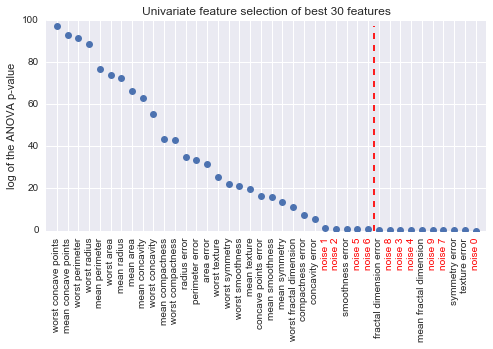

In [10]:
plt.figure(figsize=(7,5))

plt.plot(range(X_train.shape[1]), scores[indices], 'o')

plt.title('Univariate feature selection of best 30 features')
plt.ylabel('log of the ANOVA p-value')
plt.xlim([-1, X_train.shape[1]])
plt.xticks(range(X_train.shape[1]), breast_cancer_train.drop('target',axis=1).columns.values[indices], rotation=90)
plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
plt.tight_layout()

# Hack to color noise features in red
[ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

plt.show()

We see that some of our original features are actually ranked below some of the noise features. This is not surprising as the features in question are probably not very informative, either because they are very obscure ('mean fractal dimension') or they code an error of a feature. This is still not a guarantee that these features are useless, but it can serve as a simple first step in the feature selection process.

Hint: You can get a boolean mask for the selected features with `get_support()`.

**Exercise 1.1.** Instead of choosing specific number of features or a specific proportion of features to select, we can instead choose an upper limit on the proportion of *false discoveries* (that is, features for which we believe are related to the target variable when in fact they are not). Function [`sklearn.feature_selection.SelectFdr`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFdr.html#sklearn.feature_selection.SelectFdr) selects features using a Benjamini-Hochberg procedure, given an upper bound on the expected false discovery rate `alpha`. Use this function to select features with FDR rate `alpha=0.05`.

In [11]:
from sklearn.feature_selection import SelectFdr, f_classif

In [12]:
breast_cancer = pd.read_csv('breast_cancer.csv',index_col=0)

N_noise_features = 10
noise_features = pd.DataFrame(np.random.randn(breast_cancer.shape[0],N_noise_features),
                              index=breast_cancer.index,
                              columns=['noise ' + str(i) for i in range(N_noise_features)])

breast_cancer_extended = pd.concat([breast_cancer, noise_features], axis=1)

In [13]:
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer_extended, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

k_best = 30
selector = SelectFdr(f_classif, alpha=0.05)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1] # return indices that would sort an array (in reverse)

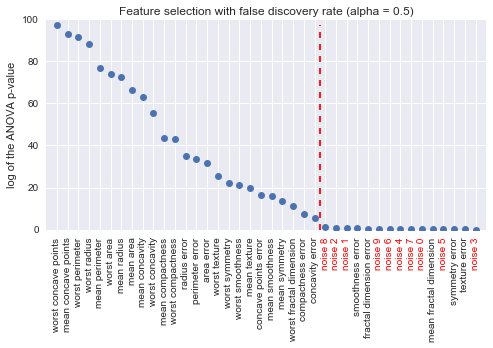

In [14]:
plt.figure(figsize=(7,5))

plt.plot(range(X_train.shape[1]), scores[indices], 'o')

plt.title('Feature selection with false discovery rate (alpha = 0.5)')
plt.ylabel('log of the ANOVA p-value')
plt.xlim([-1, X_train.shape[1]])
plt.xticks(range(X_train.shape[1]), breast_cancer_train.drop('target',axis=1).columns.values[indices], rotation=90)
plt.vlines(np.sum(selector.get_support())-0.5, 0, np.max(scores), color='red', linestyle='--')
plt.tight_layout()

# Hack to color noise features in red
[ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

plt.show()

**Exercise 1.2.** Choose a dataset with a numerical target variable and perform univariate feature selection using a regression measure, for example [`sklearn.feature_selection.f_regression`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression). You can use one of the regression datasets available in [`sklearn.datasets`](http://scikit-learn.org/dev/modules/classes.html#module-sklearn.datasets), for example [`sklearn.datasets.load_diabetes`](http://scikit-learn.org/dev/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes) or [`sklearn.datasets.load_boston`](http://scikit-learn.org/dev/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston).

1.2. Feature selection using feature importances from a predictive model
------------------------------------------------------

In comparison to model-independent feature selection methods, *model-dependant* rely on a specific predictive model to evaluate feature importances. If a predictive model provides feature importances as a step in building the model, then these importances can be used directly. This is called *transparent model* approach. Another approach is to evaluate feature importance by their contribution to the predictive performance of the model by including or excluding them before building a model. This is called *wrapper* approach. 

In the example bellow we will calculate feature importances directly using a random forest classifier, implemented in scikit-learn with [`sklearn.ensemble.RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) (regression version is [`sklearn.ensemble.RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)), which evaluates feature importance through the position in the tree where the feature is used as a split node. Features that are higher in the tree influence larger fraction of samples and can be considered as more important.

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
breast_cancer = pd.read_csv('breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)

In [17]:
forest = RandomForestClassifier(n_estimators=1000,random_state=0,n_jobs=-1) # change n_jobs for paralelism!

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1] # return indices that would sort an array (in reverse)

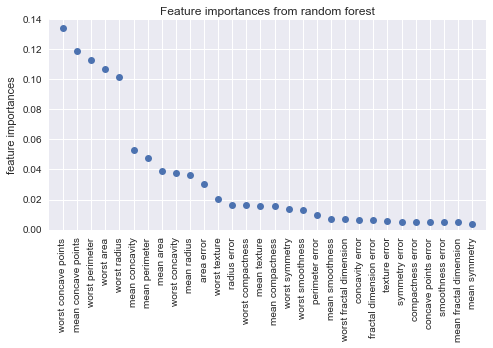

In [18]:
plt.figure(figsize=(7,5))

plt.plot(range(X_train.shape[1]), importances[indices], 'o')

plt.title('Feature importances from random forest')
plt.ylabel('feature importances')
plt.xlim([-1, X_train.shape[1]])
plt.xticks(range(X_train.shape[1]), breast_cancer_train.drop('target',axis=1).columns.values[indices], rotation=90)
plt.tight_layout()
plt.show()

**Exercise 1.3.** Each tree in a random forest ensemble evaluates feature importances individually. In the above example we plotted only the mean estimate for all trees. Calculate and plot standard deviation of all estimates. Hint: Individual trees are stored in `forest.estimators_`, and each tree has its own `feature_importances_` attribute. You can use [`matplotlib.pyplot.errorbar`](http://matplotlib.org/api/pyplot_api.html?highlight=errorbar#matplotlib.pyplot.errorbar) function for plotting. Also, take a look at the scikit-learn example ["Feature importances with forests of trees"](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py).

As each tree in the random forest ensemble evaluates feature importance individually, you can inspect the variance of the estimates:

```Python
importances_std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
```

And plot it with the code above, using Matplotlib's `errorbar` instead of `plot`: 

```Python
plt.errorbar(range(X_train.shape[1]), importances[indices], yerr=importances_std[indices], fmt='o')
```

**Exercise 1.4.** Use some other classifier for evaluation of feature importances, for example support vector machine classifier (SVC) implemented in [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). SVC calculates $k-1$ individual feature importances, where $k$ is the number of classes, and they are stored in `coef_` attribute (we have only two classes so we will get only one set of feature importances). Note: In case of SVC feature importances are available only for linear kernel. Performance note: [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) is based on [LIBSVM](http://www.csie.ntu.edu.tw/~cjlin/libsvm/) library. As an alternative, you can use [`sklearn.svm.LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) which is based on [LIBLINEAR](http://www.csie.ntu.edu.tw/~cjlin/liblinear/) library. It provides only linear kernel but scales better to large number of examples.

In [19]:
from sklearn.svm import SVC

In [20]:
svc = SVC(kernel='linear')

X_train = breast_cancer_train.drop('target',axis=1).as_matrix()
y_train = breast_cancer_train['target'].as_matrix()

svc.fit(X_train, y_train);

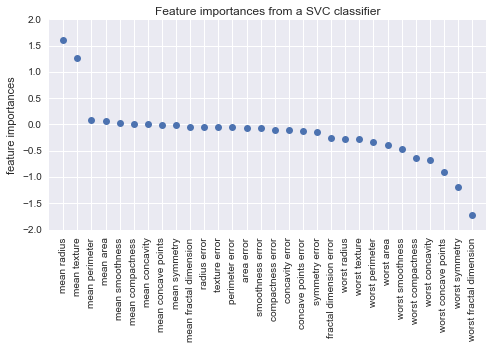

In [21]:
importances_svc = svc.coef_.flatten() # as we have two classes we have just one set of feature importances
indices_svc = np.argsort(importances_svc)[::-1] # return indices that would sort an array (in reverse)

plt.figure(figsize=(7,5))

plt.plot(range(X_train.shape[1]), importances_svc[indices_svc], 'o')

plt.title('Feature importances from a SVC classifier')
plt.ylabel('feature importances')
plt.xlim([-1, X_train.shape[1]])
plt.xticks(range(X_train.shape[1]), breast_cancer.columns.values, rotation=90)
plt.tight_layout()
plt.show()

1.3. Recursive feature elimination
--------------------------------------------

The procedure of the recursive feature elimination (also known as the *backward selection*) is the following. First, evaluate feature importances using the dataset with the full set of features, then iteratively eliminate the worst ranking feature and reevaluate. We repeat the procedure until only a desired number of features is left. Note that this is a simple greedy strategy that does not guarantee to yield best possible feature set of a given size.

Similar procedure is *forward selection*, with the exception that it starts with empty set of features and iteratively adds features one by one until desired number of them is obtained. Unfortunately, it is not implemented in scikit-learn.

We will use [`sklearn.feature_selection.RFE`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) for recursive feature elimination. Following example is inspired by ["Recursive feature elimination"](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#example-feature-selection-plot-rfe-digits-py) in scikit-learn user guide. Recursive feature elimination works on any predictive model that assigns feature importances. In the example below we will use random forest classifier implemented in [`sklearn.ensemble.RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).

In [22]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [23]:
breast_cancer = pd.read_csv('breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

In [24]:
rfe_rf = RFE(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), n_features_to_select=10, step=1)
rfe_rf.fit(X_train, y_train);

In [25]:
print "Selected features with RFE (using random forest):"
for i in list(breast_cancer_train.columns.values[:-1][rfe_rf.get_support()]): print ' - ' + str(i)

Selected features with RFE (using random forest):
 - mean texture
 - mean area
 - mean concavity
 - mean concave points
 - worst radius
 - worst texture
 - worst perimeter
 - worst area
 - worst concavity
 - worst concave points


**Exercise 1.5.** Instead of random forest, use logistic regression implemented in [`sklearn.linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) and support vector machine classifier implemented in [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) for recursive feature elimination of 10 most informative features. Compare the features you obtained with the ones above.

In [26]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [27]:
breast_cancer = pd.read_csv('breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

In [28]:
rfe_svc = RFE(SVC(kernel='linear'), n_features_to_select=10, step=1)
rfe_svc.fit(X_train, y_train);

rfe_lr = RFE(LogisticRegression(), n_features_to_select=10, step=1)
rfe_lr.fit(X_train, y_train);

In [29]:
print "\nSelected features with RFE (using SVC):"
for i in list(breast_cancer.columns.values[:-1][rfe_svc.get_support()]): print ' - ' + str(i)
    
print "\nSelected features with RFE (using logistic regression):"
for i in list(breast_cancer.columns.values[:-1][rfe_lr.get_support()]): print ' - ' + str(i)


Selected features with RFE (using SVC):
 - mean radius
 - mean concavity
 - mean concave points
 - texture error
 - worst radius
 - worst smoothness
 - worst compactness
 - worst concavity
 - worst concave points
 - worst symmetry

Selected features with RFE (using logistic regression):
 - mean radius
 - mean concavity
 - mean concave points
 - radius error
 - perimeter error
 - worst radius
 - worst perimeter
 - worst compactness
 - worst concavity
 - worst concave points


1.4. Recursive feature elimination with cross-validation
--------------------------------------------

While performing recursive feature elimination we had to define a number or a proportion of features we want to select in advance. But how many features is optimal? It would be more convenient if an algorithm could choose it for us. One of the ways to do it is with cross-validation. Feature importance is still used to decide which features to eliminate, but the optimal number of features is selected with cross-validation. For this we will use [`sklearn.feature_selection.RFECV`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) with stratified 2-fold cross-validation implemented in [`sklearn.cross_validation.StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html#sklearn.cross_validation.StratifiedKFold). For all available types of cross validation in scikit-learn see [`module-sklearn.cross_validation`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cross_validation). For a similar example see ["Recursive feature elimination with cross-validation"](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#example-feature-selection-plot-rfe-with-cross-validation-py) in scikit-learn user guide.

In [30]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [31]:
breast_cancer = pd.read_csv('breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

In [32]:
rfecv_rf = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=1, 
                 cv=StratifiedKFold(y_train, 2),
                 scoring='accuracy')
rfecv_rf.fit(X_train, y_train);

In [33]:
print "Selected features with RFECV (using random forest):"
for i in list(breast_cancer.columns.values[:-1][rfecv_rf.get_support()]): print ' - ' + str(i)

Selected features with RFECV (using random forest):
 - mean radius
 - mean texture
 - mean perimeter
 - mean area
 - mean smoothness
 - mean concavity
 - mean concave points
 - radius error
 - area error
 - compactness error
 - concavity error
 - fractal dimension error
 - worst radius
 - worst texture
 - worst perimeter
 - worst area
 - worst smoothness
 - worst compactness
 - worst concavity
 - worst concave points
 - worst symmetry
 - worst fractal dimension


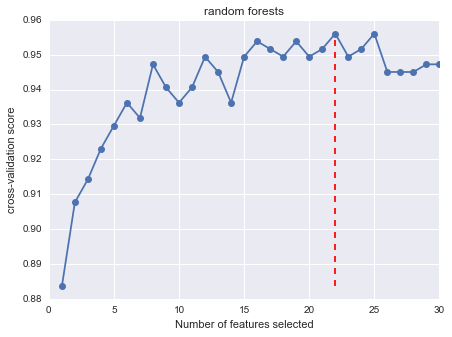

In [34]:
plt.figure(figsize=(7,5))

plt.plot(range(1, len(rfecv_rf.grid_scores_) + 1), rfecv_rf.grid_scores_, '-o')
plt.xlabel('Number of features selected')
plt.ylabel('cross-validation score')
plt.title('random forests')
plt.vlines(rfecv_rf.n_features_, 
           np.min(rfecv_rf.grid_scores_), 
           rfecv_rf.grid_scores_[rfecv_rf.n_features_-1], 
           color='red', linestyle='--')
plt.show()

**Exercise 1.6.** Instead of random forest and stratified 2-fold cross-validation use some other classifier and type of cross-validation. For example, for classifier you could use support vector machine classifier (SVC) implemented in [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) or logistic regression implemented in [`sklearn.linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression). For cross-validation you can use leave-one-out cross-validation implemented in [`sklearn.cross_validation.LeaveOneOut`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.LeaveOneOut.html#sklearn.cross_validation.LeaveOneOut) or shuffle split crossvalidation implemented in [`sklearn.cross_validation.ShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.ShuffleSplit.html#sklearn.cross_validation.ShuffleSplit). See [`module-sklearn.cross_validation`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cross_validation) for all available cross-validation types in scikit. Hint: You can use [`matplotlib.pyplot.subplot`](http://matplotlib.org/api/pyplot_api.html?highlight=subplot#matplotlib.pyplot.subplot) for plotting multiple figures.

In [35]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [36]:
breast_cancer = pd.read_csv('breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

In [37]:
rfecv_svc = RFECV(SVC(kernel='linear'), 
                 step=1, 
                 cv=StratifiedKFold(y_train, 2),
                 scoring='accuracy')
rfecv_svc.fit(X_train, y_train);

rfecv_lr = RFECV(LogisticRegression(), 
                 step=1, 
                 cv=StratifiedKFold(y_train, 2),
                 scoring='accuracy')
rfecv_lr.fit(X_train, y_train);

In [38]:
print "\nSelected features with RFECV (using SVC):"
for i in list(breast_cancer.columns.values[:-1][rfecv_svc.get_support()]): print ' - ' + str(i)
    
print "\nSelected features with RFECV (using logistic regression):"
for i in list(breast_cancer.columns.values[:-1][rfecv_lr.get_support()]): print ' - ' + str(i)


Selected features with RFECV (using SVC):
 - mean radius
 - mean concavity
 - mean concave points
 - texture error
 - worst radius
 - worst smoothness
 - worst compactness
 - worst concavity
 - worst concave points
 - worst symmetry

Selected features with RFECV (using logistic regression):
 - mean radius
 - mean texture
 - mean perimeter
 - mean smoothness
 - mean compactness
 - mean concavity
 - mean concave points
 - mean symmetry
 - mean fractal dimension
 - radius error
 - texture error
 - perimeter error
 - area error
 - concavity error
 - concave points error
 - symmetry error
 - worst radius
 - worst texture
 - worst perimeter
 - worst smoothness
 - worst compactness
 - worst concavity
 - worst concave points
 - worst symmetry
 - worst fractal dimension


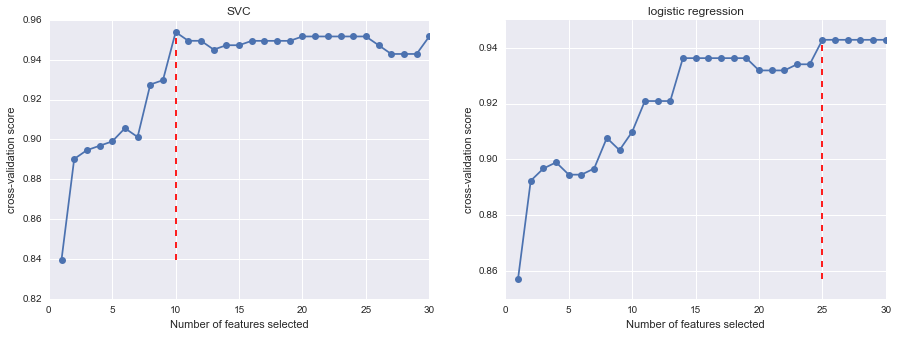

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(1, len(rfecv_svc.grid_scores_) + 1), rfecv_svc.grid_scores_, '-o')
ax[0].set(xlabel='Number of features selected',ylabel='cross-validation score',title='SVC')
ax[0].vlines(rfecv_svc.n_features_, 
             np.min(rfecv_svc.grid_scores_), 
             rfecv_svc.grid_scores_[rfecv_svc.n_features_-1], 
             color='red', linestyle='--')

ax[1].plot(range(1, len(rfecv_lr.grid_scores_) + 1), rfecv_lr.grid_scores_, '-o')
ax[1].set(xlabel='Number of features selected',ylabel='cross-validation score',title='logistic regression')
ax[1].vlines(rfecv_lr.n_features_, 
             np.min(rfecv_lr.grid_scores_), 
             rfecv_lr.grid_scores_[rfecv_lr.n_features_-1], 
             color='red', linestyle='--')

plt.show()

Literature
-----------

<a name="scikit-feature-selection">[1]</a> *"scikit-learn documentation - 1.13. Feature selection"*, [link](http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection)

<a name="pyml-ch4">[2]</a> *"Python Machine Learning Code examples - Chapter 4 - Building Good Training
Sets – Data Preprocessing"*, [link](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch04/ch04.ipynb)

<a name="intro-ml-py-ch5">[3]</a> *"Introduction to Machine Learning with Python - Chapter 5 - Representing data and engineering features"* 

<a name="diving-into-data">[4]</a> *"Diving into data - Selecting good features"*, [part 1](http://blog.datadive.net/selecting-good-features-part-i-univariate-selection/), [part 2](http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/), [part 3](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/), [part 4](http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/) 